# 2. Three phase equilibria calculation for Water (1) + CPME (2) + Ethanol (3)

In this notebook, the vapour-liquid-liquid equilibria for the mixture of Water (1) + CPME (2) + Ethanol (3) at atmospheric pressure (101325 Pa) is computed. The mixture is modelled using the SAFT-VR-Mie equation of state. All calculations are done using the [sgtpy](https://github.com/gustavochm/sgtpy) package.

This notebook is part of the Supplementary Information of the article *Assessment and modeling of the isobaric vapor-liquid-liquid equilibrium for water + cyclopentyl methyl ether + alcohol (ethanol or propan-1-ol) ternary mixtures* by Andrés Mejía, Marcela Cartes, Gustavo Chaparro and Erich A. Müller.

First, the needed packages are imported.

In [1]:
import numpy as np
from sgtpy import component, mixture, saftvrmie
from sgtpy.equilibrium import vlle
import matplotlib.pyplot as plt
import pandas as pd
from plot_utils import plot_vlle

### Mixture definition

The mixture of Water (1) + CPME (2) + Ethanol (3) and its interaction parameters are defined using the `component` and `saftvrmie` functions.

The following mixing rules are applied for the molecular parameters:

$$ \sigma_{ij} = \frac{\sigma_i + \sigma_j}{2} ; \quad \epsilon_{ij} = (1-k_{ij}) \frac{\sqrt{\sigma_i^3 \sigma_j^3}}{\sigma_{ij}^3} \sqrt{\epsilon_i \epsilon_j} ;\quad \lambda_{k,ij} = \sqrt{(\lambda_{k,i} - 3)(\lambda_{k,j} - 3)} + 3 \quad k=a,r $$

Additionally, for cross-association: 

$$ r^{ABij}_c = \frac{r^{ABii}_c + r^{ABjj}_c}{2} ;\quad r^{ABij}_d = \frac{r^{ABii}_d + r^{ABjj}_d}{2} ;\quad \epsilon_{ij}^{AB} = (1 - l_{ij})\sqrt{\epsilon_{ii}^{AB} \epsilon_{jj}^{AB}} $$

Finally, if there is induced association (e.g., cpme-water, cpme-ethanol):

$$ \epsilon_{ij}^{AB} = \frac{\epsilon^{AB}  (self-associating)}{2} ;\quad  r^{ABij}_c (fitted)$$

In [2]:
water = component('water', ms = 1.7311, sigma = 2.4539 , eps = 110.85,
                  lambda_r = 8.308, lambda_a = 6.,  eAB = 1991.07, rcAB = 0.5624,
                  rdAB = 0.4, sites = [0,2,2])

cpme = component('cpme', ms =  2.32521144, sigma = 4.13606074, eps = 343.91193798, 
                 lambda_r = 14.15484877, lambda_a = 6.0, npol = 1.91990385, mupol = 1.27,
                 sites= [0,0,1])

ethanol = component('ethanol2C', ms = 1.7728, sigma = 3.5592 , eps = 224.50,
                    lambda_r = 11.319, lambda_a = 6., eAB = 3018.05, rcAB = 0.3547,
                    rdAB = 0.4, sites = [1,0,1])

# creating mixture
mix = water + cpme + ethanol

# water (1) - cpme (2)
k12 = -0.01606063
rc12 = 2.64635702
l12 = 0.

# water (1) - ethanol (3)
k13 = -0.00699825
l13 = -0.01518442

#cpme (2) - ethanol (3)
k23 =  0.01015004
rc23 = 2.23150428
l23 = 0.

# Setting up interactions between components
Kij = np.array([[0., k12, k13], [k12, 0., k23], [k13, k23, 0.]])
Lij = np.array([[0., l12, l13], [l12, 0., l23], [l13, l23, 0.]])

mix.kij_saft(Kij)
mix.lij_saft(Lij)
# Then eos object is created
eos = saftvrmie(mix)

# Induced association between Water-CPME
eos.eABij[0,1] = water.eAB / 2
eos.eABij[1,0] = water.eAB / 2
eos.rcij[0,1] = rc12 * 1e-10
eos.rcij[1,0] = rc12 * 1e-10

# Induced association between CPME-Ethanol
eos.eABij[1,2] = ethanol.eAB / 2
eos.eABij[2,1] = ethanol.eAB / 2
eos.rcij[1,2] = rc23 * 1e-10
eos.rcij[2,1] = rc23 * 1e-10

### Phase equilibria calculation
Three-phase equilibria is computed by solving the following modified [multiphase flash](https://www.sciencedirect.com/science/article/pii/037838129180021M):

$$ \sum_{i=1}^c \frac{z_i (K_{ik} \exp{\theta}-1)}{1+ \sum\limits^{\pi}_{\substack{j=1 \\ j \neq r}}{\beta_j (K_{ij}} \exp{\theta_j} -1)} = 0 \qquad k = 1,..., \pi,  k \neq r $$

Subject to:

$$ \beta_k \theta_k = 0 $$

In this system of equations, $z_i$ represents the global composition of the component $i$,  $ K_{ij} = x_{ij}/x_{ir} = \hat{\phi}_{ir}/\hat{\phi}_{ij} $ is the constant equilibrium of component $i$ in phase $j$ respect to the reference phase $r$, and $\beta_j$ and $\theta_j$ are the phase fraction and stability variable of the phase $j$. The stability variables $\theta_j$ are zero for stable phases and positive for unstable phases.

If the maximum number of successive substitutions is reached, the solver changes from solving this multiphase flash to minimising the Gibbs free energy. The solver is implemented in `sgtpy` via the `vlle` function.

#### VLLE calculation strategy

The three-phase equilibria will be computed in the same temperature range as the experimental data. A complete exploration of the entire VLLE envelope can be done using the stability analysis explained on Notebook 1).

It is convenient to start the calculation from the binary Water (1) + CPME (2). Then, the ternary VLLE is then computed by decreasing the temperature while increasing the alcohol global composition. 

In [3]:
P = 1.01325e5 # Pa

# creating empty arrays to store the results
n = 200
X = np.zeros([n,3])
W = np.zeros([n,3])
Y = np.zeros([n,3])

vx = np.zeros(n)
vw = np.zeros(n)
vy = np.zeros(n)


# Phase equilibria is initialized from the binary Water (1) + CPME (3)
i = 0
T00 = 356. # K
X0 = np.array([0.05434099, 0.94565901, 0.])
W0 = np.array([0.9988717,  0.0011283,  0.])
Y0 = np.array([0.52175434, 0.47824566, 0.])
Z = (X0+W0+Y0)/3

# The vlle routine will recognize there is only two components in the mixture
# hence it will update the VLLE temperature
sol = vlle(X0, W0, Y0, Z, T00, P, eos, full_output=True)

T0 = sol.T
X[i], W[i], Y[i] = sol.X
vx[i], vw[i], vy[i] = sol.v
sol

/Users/gac21/Documents/sgtpy/sgtpy/equilibrium/hazt.py:263: UserWarning: Global mixture is a binary mixture, updating temperature
  warn('Global mixture is a binary mixture, updating temperature')


       T: 356.16261074266754
       P: 101325.0
       X: array([[0.0680594 , 0.9319406 , 0.        ],
       [0.99775532, 0.00224468, 0.        ],
       [0.52443908, 0.47556092, 0.        ]])
       v: [0.00011733370985518894, 1.855497121209013e-05, 0.028571633225013493]
    Xass: [array([0.20641363, 0.87015986, 0.90305354, 0.12603407, 0.7618659 ]), array([0.10642025, 0.10738928, 0.13853913, 0.02701593, 0.05285918]), array([0.98885486, 0.99137806, 0.99443493, 0.96401233, 0.98348038])]
  states: ['L', 'L', 'V']
 success: True

After the binary VLLE is computed, we proceed to compute the ternary VLLE. We obtain the global composition of the previous calculation and slightly increase the alcohol composition of the mixture.

In [4]:
T = np.linspace(T0, 350., n)
i = 1 
# Global composition is obtained from previous result
Z = (X[i-1] + W[i-1] + Y[i-1]) / 3
# The alcohol composition is slightly increased
Z[2] += 0.0005
Z /= Z.sum()

# The VLLE is solved for the given Z, T, P.
sol = vlle(X[i-1], W[i-1], Y[i-1], Z, T[i], P, eos, full_output = True,
           v0 =[vx[i-1], vw[i-1], vy[i-1]], K_tol=1e-14, nacc=15)
X[i], W[i], Y[i] = sol.X
vx[i], vw[i], vy[i] = sol.v
sol

           T: 356.1316428494883
           P: 101325.0
 error_outer: 8.041301516915484e-16
 error_inner: 6.4477968186956275e-09
        iter: 12
        beta: array([0.43020541, 0.42648714, 0.14330745])
       tetha: array([0., 0., 0.])
           X: array([[6.81948410e-02, 9.31349670e-01, 4.55488759e-04],
       [9.97520409e-01, 2.25128997e-03, 2.28300570e-04],
       [5.23715101e-01, 4.74844435e-01, 1.44046332e-03]])
           v: [0.0001172859259393331, 1.8564347939867968e-05, 0.028567820881108506]
        Xass: [array([0.20622065, 0.86945163, 0.90260259, 0.1258514 , 0.76070894]), array([0.1063731 , 0.10745285, 0.13864738, 0.02701608, 0.05288707]), array([0.98881997, 0.99136289, 0.9944299 , 0.96395863, 0.98345118])]
      states: ['L', 'L', 'V']

Now that one VLLE point for the ternary mixture has been computed, the VLLE at different temperatures will be computed similarly to before using a `for` loop. The global composition and initial guesses will be taken from the previously computed points. 

In order to keep track of the calculation, the temperature, liquid phase compositions and stability variables are printed. 

In [5]:
print('Point \t Temperature \t  X \t \t \t \t  W \t \t \t \t theta')
last_index = 0
for i in range(2, n):
    last_index = i
    # getting global composition from previous point
    Z = (X[i-1] + W[i-1] + Y[i-1])/3
    sol = vlle(X[i-1], W[i-1], Y[i-1], Z, T[i], P, eos, full_output = True, 
               v0 =[vx[i-1], vw[i-1], vy[i-1]], K_tol=1e-14, nacc=15)
    # checking if the result converged to VLLE
    if np.all(sol.tetha == 0) and np.all(sol.beta > 0):
        # saving the computed results
        X[i], W[i], Y[i] = sol.X
        vx[i], vw[i], vy[i] = sol.v
        print(i, '\t', f'{T[i]:.2f}', '\t', f'[{X[i, 0]:.4f}, {X[i, 1]:.4f}, {X[i, 2]:.4f}]', 
              '\t', f'[{W[i, 0]:.4f}, {W[i, 1]:.4f}, {W[i, 2]:.4f}]', '\t', sol.tetha)
    else:
        print(f'Point {i} at temperature {T[i]:.2f} converged to either VLE or LLE')
        print('Stopping loop')
        break

Point 	 Temperature 	  X 	 	 	 	  W 	 	 	 	 theta
2 	 356.10 	 [0.0683, 0.9308, 0.0009] 	 [0.9973, 0.0023, 0.0005] 	 [0. 0. 0.]
3 	 356.07 	 [0.0685, 0.9302, 0.0014] 	 [0.9970, 0.0023, 0.0007] 	 [0. 0. 0.]
4 	 356.04 	 [0.0686, 0.9296, 0.0018] 	 [0.9968, 0.0023, 0.0009] 	 [0. 0. 0.]
5 	 356.01 	 [0.0687, 0.9290, 0.0023] 	 [0.9966, 0.0023, 0.0012] 	 [0. 0. 0.]
6 	 355.98 	 [0.0689, 0.9283, 0.0028] 	 [0.9963, 0.0023, 0.0014] 	 [0. 0. 0.]
7 	 355.95 	 [0.0690, 0.9277, 0.0032] 	 [0.9961, 0.0023, 0.0016] 	 [0. 0. 0.]
8 	 355.91 	 [0.0692, 0.9271, 0.0037] 	 [0.9958, 0.0023, 0.0019] 	 [0. 0. 0.]
9 	 355.88 	 [0.0693, 0.9265, 0.0042] 	 [0.9956, 0.0023, 0.0021] 	 [0. 0. 0.]
10 	 355.85 	 [0.0695, 0.9259, 0.0047] 	 [0.9954, 0.0023, 0.0023] 	 [0. 0. 0.]
11 	 355.82 	 [0.0696, 0.9252, 0.0052] 	 [0.9951, 0.0023, 0.0026] 	 [0. 0. 0.]
12 	 355.79 	 [0.0697, 0.9246, 0.0056] 	 [0.9949, 0.0023, 0.0028] 	 [0. 0. 0.]
13 	 355.76 	 [0.0699, 0.9240, 0.0061] 	 [0.9946, 0.0023, 0.0031] 	 [0. 0. 0.]
14 	 355.7

### Plotting the results

The results are plotted using the [ternary package](https://github.com/marcharper/python-ternary) and the [matplotlib 3D library](https://matplotlib.org/stable/index.html).

The experimental data is read using pandas.

In [6]:
# reading experimental data
df = pd.read_excel('experimental_data.xlsx', index_col=0)

Texp = df['Temperature / K'].to_numpy()
Xexp = df[['X (water)', 'X (CPME)', 'X (ethanol)']].to_numpy()
Wexp = df[['W (water)', 'W (CPME)', 'W (ethanol)']].to_numpy()
Yexp = df[['Y (water)', 'Y (CPME)', 'Y (ethanol)']].to_numpy()

df.head(n =3)

,Pressure / Pa,Temperature / K,X (water),X (CPME),X (ethanol),W (water),W (CPME),W (ethanol),Y (water),Y (CPME),Y (ethanol)
Point,,,,,,,,,,,
1,101325,350.37,0.303257,0.435049,0.261694,0.883163,0.008191,0.108646,0.363288,0.322674,0.314038
2,101325,350.45,0.270809,0.489747,0.239443,0.863123,0.033964,0.102913,0.373195,0.326598,0.300207
3,101325,350.85,0.180991,0.643103,0.175906,0.921899,0.008038,0.070063,0.378809,0.342296,0.278894


Finally the ternary plot are shown below:

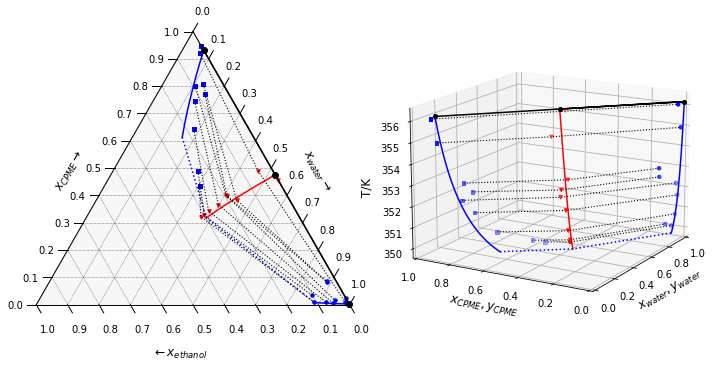

In [7]:

saft_data = {'X':X, 'W':W, 'Y': Y, 'T': T}
exp_data = {'X':Xexp, 'W':Wexp, 'Y': Yexp, 'T': Texp}
plot_vlle(saft_data, exp_data);